In [1]:
import torch
from torch import nn
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
import models
import training
from torchvision.transforms import v2
import numpy as np
import matplotlib.pyplot as plts
from os.path import join
import torchvision
import torch.nn.functional as F
import h5py
import matplotlib.pyplot as plt
from torch.utils.data import random_split

device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

def format_data(x):
    mean = [x[:, n, :, :].mean() for n in range(x.shape[1])]
    std = [x[:, n, :, :].std() for n in range(x.shape[1])]

    X = v2.Compose([
            torch.from_numpy,
            v2.Normalize(mean=mean, std=std),
            v2.Resize((64, 64)),
        ])(x).to(device)
    return X

Using cuda device


In [2]:
orders = range(1,2)

for order in orders:
    with h5py.File('../../Data/Training/intense_mixed_noiseless.h5', 'r') as f:
        images = format_data(f[f'images_order{order}'][:])
        labels = torch.from_numpy(f[f'labels_order{order}'][:]).to(device)

    dset = TensorDataset(images, labels)

    train_size = int(0.85 * len(dset))
    test_size = len(dset) - train_size

    train_dataset, test_dataset = random_split(dset, [train_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=256)

    L = images.shape[2]
    loss_fn = torch.nn.MSELoss()
    n_channels = 2
    n_classes = (order+1)**2-1

    model = models.ConvNet(L,L,n_channels, n_classes,[24,40,35],5,nn.ELU,[120,80,40]).to(device)

    optimizer = torch.optim.Adam(model.parameters(), amsgrad=True)

    save_path = f"../../Results/MachineLearningModels/Intense/Mixed_Order{order}_v3"

    writer = SummaryWriter(save_path)
    early_stopping = training.EarlyStopping(patience=50,save_path=save_path)
    for t in range(200):
        epoch = t+1
        print(f"-------------------------------\nEpoch {epoch}")
        training.train(model, train_loader, loss_fn, optimizer, device)
        val_loss = training.test(model, test_loader, loss_fn, device, epoch, writer, verbose=True)
        early_stopping(val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break
    print("Done!")
    writer.close()
        

-------------------------------
Epoch 1
Training loss: 0.00001301
-------------------------------
Epoch 2
Training loss: 0.00000699
-------------------------------
Epoch 3
Training loss: 0.00001913
-------------------------------
Epoch 4
Training loss: 0.00000168
-------------------------------
Epoch 5
Training loss: 0.00002643
-------------------------------
Epoch 6
Training loss: 0.00000530
-------------------------------
Epoch 7
Training loss: 0.00000152
-------------------------------
Epoch 8
Training loss: 0.00000484
-------------------------------
Epoch 9
Training loss: 0.00001540
-------------------------------
Epoch 10
Training loss: 0.00000169
-------------------------------
Epoch 11
Training loss: 0.00000363
-------------------------------
Epoch 12
Training loss: 0.00000075
-------------------------------
Epoch 13
Training loss: 0.00000305
-------------------------------
Epoch 14
Training loss: 0.00000163
-------------------------------
Epoch 15
Training loss: 0.00000123
----

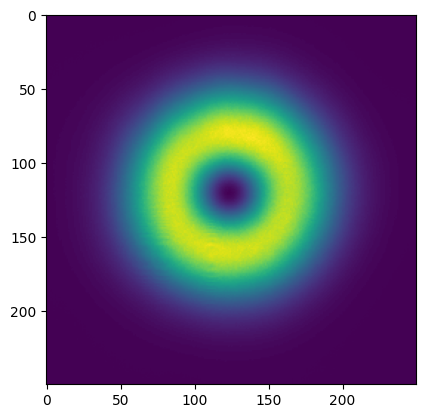

In [22]:
with h5py.File('../../Data/Processed/mixed_intense.h5') as f:
        images = f['images_order1'][:]

plt.imshow(images[3,0,80:330,80:330])

In [5]:
orders = range(1,2)


for order in orders:
    with h5py.File('../../Data/Processed/mixed_intense.h5') as f:
        images_exp = format_data(f[f'images_order{order}'][:,:,80:330,80:330]).float()
        labels_exp = f[f'labels_order{order}'][:]
    

    model = torch.load(f"../../Results/MachineLearningModels/Intense/Mixed_Order{order}_v1/checkpoint.pt")

    with torch.no_grad():
        labels_pred = model(images_exp).cpu().numpy()
        with h5py.File("../../Results/Intense/machine_learning.h5", 'w-') as out:
            out.create_dataset(f'pred_labels_order{order}', data=labels_pred)
            out.create_dataset(f'labels_order{order}', data=labels_exp)